In [1]:
import pandas as pd
import nltk 
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression, SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

In [2]:
data = pd.read_csv("IMDB Dataset.csv")
data.count()[0]
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
data["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
d = {"negative": 0, "positive": 1}

# Convert sentiment into numerical data 
data["sentiment"] = data["sentiment"].map(d)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [6]:
stop_words = set(stopwords.words('english'))

# Define function to remove irrelevant words and symbols from reviews
def extract_words(text):
    tokens = word_tokenize(text) #split sentence into words
    sent = []
    for word in tokens:
        if word.isalpha() and word not in stop_words and word !="br":
            sent.append(word.lower())
    return " ".join(sent)
        
data["review"] = data["review"].apply(extract_words)
data["review"].head()   

0    one reviewers mentioned watching oz episode ho...
1    a wonderful little production the filming tech...
2    i thought wonderful way spend time hot summer ...
3    basically family little boy jake thinks zombie...
4    petter mattei love time money visually stunnin...
Name: review, dtype: object

In [7]:

X_train, X_test, y_train, y_test = train_test_split(data, data["sentiment"], test_size=0.2, random_state=64) 

# 20% of the data is used for testing, 80% for training 

## TF-IDF Vectorizer: 
- Term frequency: Frequency of a word in a review
- Inverse document frequency: Log of the ratio of the total number of reviews to the number of reviews that contain the word -> assigns a higher weight to words that are more rare.

$$
\left[
\begin{matrix}
 & \text{Word 1} & \text{Word 2} & \text{Word 3} & \text{Word 4} & \text{Word 5}& \text{---} & \text{---}  \\
\text{Review 1} & - & - & - & - & - & - & -\\
\text{Review 2} & - & - & - & - & - & - & -\\
\text{Review 3} & - & - & - & - & - & - & -\\
\text{Review 4} & - & - & - & - & - & - & -\\
\text{Review 5} & - & - & - & - & - & - & -\\
\text{-} & - & - & - & - & - & - & -\\
\text{-} & - & - & - & - & - & - & -\\
\end{matrix}
\right]
$$

In [8]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train["review"])
X_test = vectorizer.transform(X_test["review"]) # to ensure same transformations are applied to test data as train data 


### Multinomial Naive Bayes Model
- Useful for analysis of sparse data, high dimensional data with lots of features
- assumes independence of features
- Uses Bayes theorem to assign probabilities for categorization 

$ P(Sentiment | Words) = \frac{P(Words | Sentiment) \times P(Sentiment)}{P(Words)} $




In [9]:
# Prediction array for Multinomial Naive Bayes model
nb_model = MultinomialNB() 
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)


In [10]:
# Test the accuracy of the NB model
nb_acc = accuracy_score(y_test, nb_pred)
print("Accuracy for Multinomial NB:", nb_acc)

Accuracy for Multinomial NB: 0.8632


In [11]:
nb_cm = metrics.confusion_matrix(y_test,nb_pred)
nb_cm

array([[4362,  589],
       [ 779, 4270]])

### Logistic Regression Model
- Uses sigmoid function to map input features to a probability between 0 and 1
- Minimizes loss function to estimate parameters of sigmoid function
- Useful for large dataset

$$
f(z) = \frac{1}{1+e^{-z}}
$$

where $z$ is a linear combination of predictors and coefficients

In [12]:
# Prediction array for Logsitic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

In [13]:
# Test the accuracy of the LR model
lr_acc = accuracy_score(y_test, lr_pred)
print("Accuracy for Logistic Regression:", lr_acc)

Accuracy for Logistic Regression: 0.8926


In [14]:
lr_cm = metrics.confusion_matrix(y_test,lr_pred)
lr_cm

array([[4358,  593],
       [ 481, 4568]])

The confusion matrix of the Multinomial Bayes model it has a higher success rate at classifying negative sentiment as compared to positive sentiment whereas the inverse is true for the Logistic Regression model. 
Thus I chose to combine the two models as shown below

In [15]:
# Get the prediction probability arrays of both models
lr_prob = lr_model.predict_proba(X_train)
nb_prob = nb_model.predict_proba(X_train)

In [16]:
best_acc = 0
best_weights = []

# Determine which weights for the models result in the highest accuracy
for i in range(1, 5000):
    lr_weight = i / 5000
    nb_weight = 1 - lr_weight
    weighted_predict = (lr_weight * lr_prob) + (nb_weight * nb_prob)
    combined_pred = weighted_predict.argmax(axis=1)
    acc = accuracy_score(y_train, combined_pred)
    if acc > best_acc:
        best_acc = acc
        best_weights = (lr_weight, nb_weight)

print("Best accuracy:", best_acc)
print("Best weights:", best_weights)

Best accuracy: 0.9364
Best weights: (0.7028, 0.2972)


In [17]:
# Use above determined weights to create a function that gives the prediction array based on the combined model
def combined_prediction(X_val):
    weight = best_weights[0] * lr_model.predict_proba(X_val) + best_weights[1] * nb_model.predict_proba(X_val)
    return weight.argmax(axis = 1)

combined_pred = combined_prediction(X_test)

In [18]:
# Test accuracy of combined model
acc = accuracy_score(y_test, combined_pred)
print("Combined Accuracy:", acc)

Combined Accuracy: 0.8952


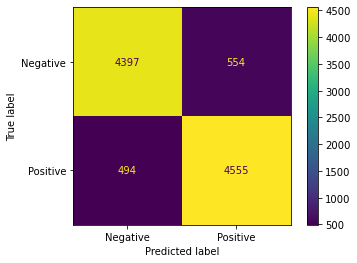

In [19]:
combined_cm = metrics.confusion_matrix(y_test, combined_pred)
comb_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = combined_cm, display_labels = ["Negative", "Positive"])
comb_cm_display.plot()
plt.show()

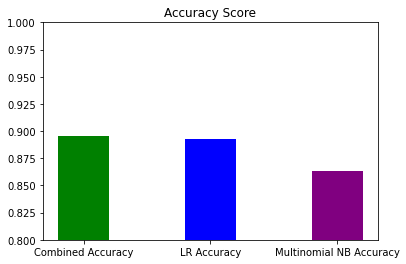

In [20]:
x = [0, 2, 4]
labels = ['Combined Accuracy', 'LR Accuracy', 'Multinomial NB Accuracy']

heights = [acc, lr_acc, nb_acc]

plt.bar(x, heights, tick_label=labels, color = ["green", "Blue", "Purple"])
plt.ylim(0.8, 1.0)
plt.title('Accuracy Score')
plt.show() # it can be seen that the combined accuracy is the highest 

### Generalizability of the model

#### Yelp Review data

In [21]:
yelp_test = pd.read_csv("yelp_labelled.csv", header = None)
yelp_test.head()

,0,1,2,3,4,5
0,Wow... Loved this place.,1,NaN,NaN,NaN,NaN
1,Crust is not good.,0,NaN,NaN,NaN,NaN
2,Not tasty and the texture was just nasty.,0,NaN,NaN,NaN,NaN
3,Stopped by during the late May bank holiday of...,1,NaN,NaN,NaN,NaN
4,The selection on the menu was great and so wer...,1,NaN,NaN,NaN,NaN


In [22]:
yelp = pd.DataFrame(columns=["Review", "Sentiment"])

# Create a new dataframe to improve data format 
for index, row in yelp_test.iterrows(): # iterate over rows of yelp_test
    Review = ""
    Sentiment = 0
    for col in row:
        if isinstance(col, str): # remove NaN
            if col.isdigit():
                Sentiment = col # Convert string sentiment values to integers
            else:
                Review += col
    new_row = {"Review": Review, "Sentiment": Sentiment}
    yelp = yelp.append(new_row, ignore_index=True)

yelp["Sentiment"] = pd.to_numeric(yelp["Sentiment"])
yelp.head()

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [23]:
# Remove irreleavant words and symbols from Review column
yelp["Review"] = yelp["Review"].apply(extract_words)

In [24]:
# Apply TF-IDF Vectorizer to Review column
yelp_vector = vectorizer.transform(yelp["Review"])


In [25]:
# Create function to test accuracy of Logistic Regression model
def logistic_accuracy(correct_vals, vector):
    return accuracy_score(correct_vals, lr_model.predict_proba(vector).argmax(axis=1))

y_lr_acc = logistic_accuracy(yelp["Sentiment"], yelp_vector)
np.round(y_lr_acc,2)

0.75

In [26]:
# Create function to test accuracy of Multinomial Bayes model
def multinomialnb_accuracy(correct_vals, vector):
    return accuracy_score(correct_vals, nb_model.predict_proba(vector).argmax(axis=1))

y_nb_acc = multinomialnb_accuracy(yelp["Sentiment"], yelp_vector)
np.round(y_nb_acc,2)

0.71

In [27]:
# Create combined model and test accuracy
combined_yelp = combined_prediction(yelp_vector)
yelp_acc = accuracy_score(yelp["Sentiment"], combined_yelp)
np.round(yelp_acc, 2)

0.76

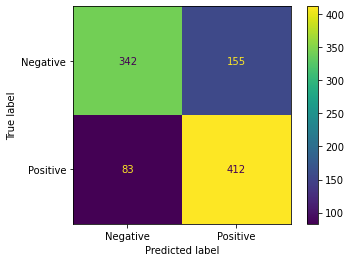

In [28]:
# Create and plot confusion matrix for combined model 
cm_yelp = metrics.confusion_matrix(yelp["Sentiment"],combined_yelp)
y_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_yelp, display_labels = ["Negative", "Positive"])
y_cm_display.plot()
plt.show()

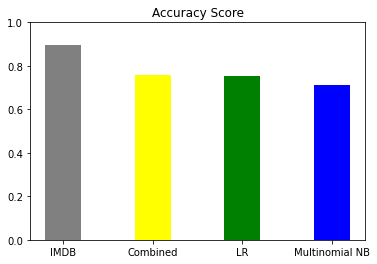

In [29]:
x = [0, 2, 4, 6]
labels = ['IMDB', 'Combined', 'LR', 'Multinomial NB']

heights = [acc, yelp_acc, y_lr_acc, y_nb_acc]
c = ['grey', 'yellow', 'green', 'blue']

plt.bar(x, heights, tick_label=labels, color = c)
plt.ylim(0, 1.0)
plt.title('Accuracy Score')
plt.show()

#### Amazon Review data

In [30]:
# Read in and format Amazon review dataset
amazon_test = pd.read_csv("amazon_cells_labelled.csv", header = None)
amazon = pd.DataFrame(columns=["Review", "Sentiment"])

for index, row in amazon_test.iterrows():
    Review = ""
    Sentiment = 0
    for col in row:
        if isinstance(col, str):
            if col.isdigit():
                Sentiment = col
            else:
                Review += col
    new_row = {"Review": Review, "Sentiment": Sentiment}
    amazon = amazon.append(new_row, ignore_index=True)

amazon["Sentiment"] = pd.to_numeric(amazon["Sentiment"])

amazon.head()

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,Good case Excellent value.,1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [31]:
# Clean and Vectorize Review column
amazon["Review"] = amazon["Review"].apply(extract_words)
amazon_vector = vectorizer.transform(amazon["Review"])

# Print the accuracy fo LR and Multinomial NB models
a_lr_acc = logistic_accuracy(amazon["Sentiment"], amazon_vector)
a_nb_acc = multinomialnb_accuracy(amazon["Sentiment"], amazon_vector)
print(a_lr_acc, a_nb_acc)

0.759 0.715


In [32]:
# Test the combined model accuracy
combined_amazon = combined_prediction(amazon_vector)
amazon_acc = accuracy_score(amazon["Sentiment"], combined_amazon)
amazon_acc

0.766

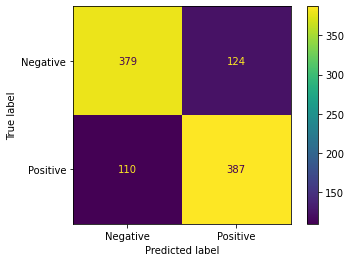

In [33]:
# Display the confusion matrix for the combined model
cm_amazon = metrics.confusion_matrix(amazon["Sentiment"],combined_amazon)
a_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_amazon, display_labels = ["Negative", "Positive"])
a_cm_display.plot()
plt.show()

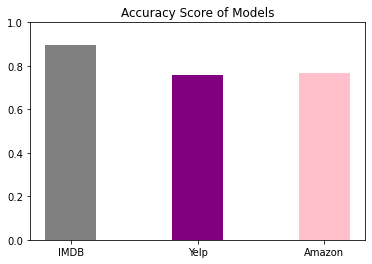

In [34]:
# Cross comparison of the Combined model results on all three review types

x = [0, 2, 4]
labels = ['IMDB', 'Yelp', 'Amazon']

heights = [acc, yelp_acc, amazon_acc]
c = ['grey', 'purple', 'pink']

plt.bar(x, heights, tick_label=labels, color = c)
plt.ylim(0, 1)
plt.title('Accuracy Score of Models')
plt.show()